In [26]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
from main import target_renamer, forecast_maker, data_slicer
from Models.lstm import LSTM
from Data.Featurisation import Featurisation

In [27]:
lags = 24
forecast_period=24
hidden_size = 100
num_layers = 4
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
month_data = True #1 month of data for testing new code

month_range = pd.date_range("2019-08-01", "2019-08-31 23:00", freq='h', tz="UTC")
source_range = pd.date_range("2016-05-01","2019-12-31 23:00", freq='h', tz="UTC")
target_month = pd.date_range("2020-08-01", "2020-08-31 23:00", freq='h', tz="UTC")
eval_month = pd.date_range("2019-07-01", "2021-07-31 23:00", tz="UTC", freq='h')

# 0. Data initialization

In [29]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')

CEDA = pd.read_pickle("CEDA_dataNL.pickle")

meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation_instant": "downward_surface_SW_flux",
              "diffuse_radiation_instant":"diffuse_surface_SW_flux",
              "direct_normal_irradiance_instant":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)


In [30]:
openmeteo

,temperature_1_5m,relative_humidity_1_5m,pressure_MSL,total_cloud_amount,downward_surface_SW_flux,diffuse_surface_SW_flux,direct_surface_SW_flux,wind_speed_10m,wind_direction_10m
date,,,,,,,,,
2016-05-01 00:00:00+00:00,3.681,89.286,"1,025.300",0.000,0.000,0.000,0.000,11.166,358.152
2016-05-01 01:00:00+00:00,3.181,90.854,"1,025.800",0.000,0.000,0.000,0.000,9.029,4.574
2016-05-01 02:00:00+00:00,2.830,91.482,"1,026.200",2.100,0.000,0.000,0.000,10.080,360.000
2016-05-01 03:00:00+00:00,2.631,91.797,"1,026.200",10.200,0.000,0.000,0.000,11.885,1.736
2016-05-01 04:00:00+00:00,2.580,91.794,"1,026.600",18.000,0.000,0.000,0.000,9.470,8.746
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,10.850,94.807,"1,019.700",100.000,0.000,0.000,0.000,21.898,242.592
2021-12-31 20:00:00+00:00,11.150,93.561,"1,020.600",100.000,0.000,0.000,0.000,22.057,243.853
2021-12-31 21:00:00+00:00,11.200,94.190,"1,021.100",100.000,0.000,0.000,0.000,22.265,247.166


52.0499 5.07391 3100 5 33
                                P
timestamp                        
2019-01-10 15:00:00+00:00   0.000
2019-01-10 16:00:00+00:00   0.000
2019-01-10 17:00:00+00:00   0.000
2019-01-10 18:00:00+00:00   0.000
2019-01-10 19:00:00+00:00   0.000
...                           ...
2021-08-09 16:00:00+00:00 954.000
2021-08-09 17:00:00+00:00 337.000
2021-08-09 18:00:00+00:00 100.000
2021-08-09 19:00:00+00:00   5.000
2021-08-09 20:00:00+00:00   0.000

[22614 rows x 1 columns]


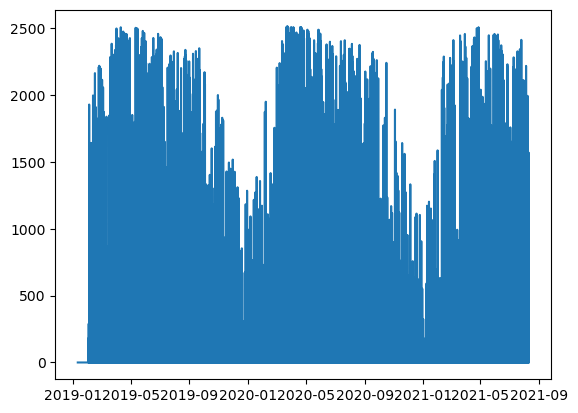

In [31]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power = power.resample('h').sum()/4
power = power.tz_localize('UTC')
#power.index = power.index.shift(periods=2)
print(latitude, longitude, peakPower, azimuth, tilt)
plt.plot(power)
print(power)


In [32]:
#target and evaluation data will stay the same most probablyy
target_CEDA = data_slicer(CEDA, target_month)
target_power = data_slicer(power, target_month)
eval_CEDA = data_slicer(CEDA, eval_month)
eval_power = data_slicer(power, eval_month)

#TARGET DATASET
target_dataset = pd.merge(target_power, target_CEDA, left_index=True, right_index=True, how='inner')
data = [target_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

target_dataset = data.data[0]

## EVALUATION DATASET
eval_dataset = pd.merge(eval_power, eval_CEDA, left_index=True, right_index=True, how='inner')
data = [eval_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

eval_dataset = data.data[0]
print(eval_dataset)


                               P  temperature_1_5m  relative_humidity_1_5m  \
2019-07-01 00:00:00+00:00  0.000           288.501                  91.278   
2019-07-01 01:00:00+00:00  0.000           288.501                  91.278   
2019-07-01 02:00:00+00:00  0.000           288.444                  92.937   
2019-07-01 03:00:00+00:00  0.000           288.432                  94.159   
2019-07-01 04:00:00+00:00 57.000           288.785                  93.788   
...                          ...               ...                     ...   
2021-07-31 19:00:00+00:00 27.000           291.174                  77.048   
2021-07-31 20:00:00+00:00  0.000           290.445                  80.800   
2021-07-31 21:00:00+00:00  0.000           289.453                  85.674   
2021-07-31 22:00:00+00:00  0.000           289.241                  85.318   
2021-07-31 23:00:00+00:00  0.000           288.321                  92.201   

                           total_cloud_amount  diffuse_surface_

# 1. NWP data

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X | CEDA | CEDA|
| Y | PVGIS    | Prod NL|

In [33]:
from Data.Featurisation import Featurisation

source_pvgis = data_slicer(pvgis, source_range)
source_CEDA = data_slicer(CEDA, source_range)


data = pd.merge(source_pvgis, source_CEDA, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')


source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

min = source_dataset.min(axis=0)
max = source_dataset.max(axis=0)
print(pd.merge(source_dataset.describe(include='all'), eval_dataset.describe(include='all'), left_index=True, right_index=True, suffixes=("_source", "_eval")))



       P_source  temperature_1_5m_source  relative_humidity_1_5m_source  \
count   744.000                  744.000                        744.000   
mean    509.594                  291.820                         72.312   
std     686.241                    4.291                         17.144   
min       0.000                  282.896                         25.500   
25%       0.000                  288.857                         59.738   
50%      96.040                  291.761                         76.078   
75%     912.237                  294.210                         85.868   
max   2,322.300                  305.799                         98.134   

       total_cloud_amount_source  diffuse_surface_SW_flux_source  \
count                    744.000                         744.000   
mean                       0.748                          75.791   
std                        0.349                          91.828   
min                        0.000                    

In [34]:
print((source_dataset.corr()-eval_dataset.corr()).loc['P'])
print(source_dataset.corr().loc['P'])
print(eval_dataset.corr().loc['P'])


P                           0.000
temperature_1_5m            0.181
relative_humidity_1_5m     -0.023
total_cloud_amount          0.265
diffuse_surface_SW_flux    -0.020
direct_surface_SW_flux      0.011
downward_surface_SW_flux   -0.014
pressure_MSL               -0.005
wind_speed_10m              0.171
wind_direction_10m          0.110
hour_sin                    0.005
hour_cos                   -0.140
month_sin                     NaN
month_cos                     NaN
P_24h_shift                 0.013
wind_direction_10m_cos     -0.168
wind_direction_10m_sin     -0.133
Name: P, dtype: float64
P                           1.000
temperature_1_5m            0.584
relative_humidity_1_5m     -0.673
total_cloud_amount          0.074
diffuse_surface_SW_flux     0.732
direct_surface_SW_flux      0.850
downward_surface_SW_flux    0.902
pressure_MSL                0.163
wind_speed_10m              0.184
wind_direction_10m          0.016
hour_sin                    0.097
hour_cos                

In [35]:
tuning_method = 'freeze'
features = list(source_dataset.columns)
print(features)

['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'total_cloud_amount', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'downward_surface_SW_flux', 'pressure_MSL', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift', 'wind_direction_10m_cos', 'wind_direction_10m_sin']


Shape of data:  torch.Size([24, 24, 16]) torch.Size([6, 24, 16]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
Step 0: Average train loss: 0.1256 | Average test loss: 0.1464
Step 5: Average train loss: 0.0432 | Average test loss: 0.0401
Step 10: Average train loss: 0.0260 | Average test loss: 0.0322
Step 15: Average train loss: 0.0274 | Average test loss: 0.0228
Step 20: Average train loss: 0.0252 | Average test loss: 0.0252
Step 25: Average train loss: 0.0253 | Average test loss: 0.0204
Step 30: Average train loss: 0.0236 | Average test loss: 0.0197
Step 35: Average train loss: 0.0189 | Average test loss: 0.0231
Step 40: Average train loss: 0.0164 | Average test loss: 0.0157
Step 45: Average train loss: 0.0130 | Average test loss: 0.0113
Step 50: Average train loss: 0.0130 | Average test loss: 0.0136
Step 55: Average train loss: 0.0108 | Average test loss: 0.0120
Step 60: Average train loss: 0.0098 | Average test loss: 0.0120
Step 65: Average train loss: 0.0098 | Average test loss: 0

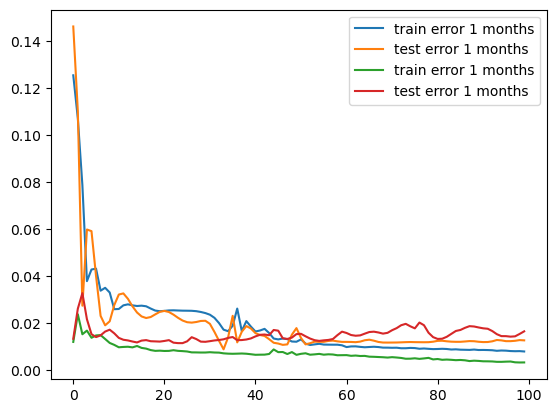

In [36]:
source_state_dict, target_state_dict, y_truth, y_forecast = forecast_maker(source_dataset, target_dataset, features, eval_dataset, [min,max])

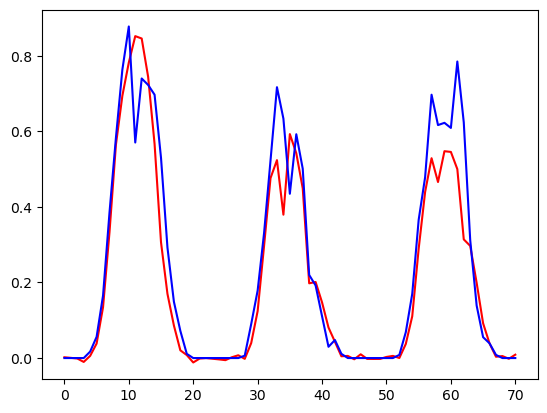

In [37]:
plt.figure()

day = 15
plt.plot(y_forecast[(24*day):(24*day)+71], color='red')
plt.plot(y_truth[(24*day):(24*day)+71], color='blue')

# 2. Historic weather 

Case study 2:
|   | Source   | Target |
|---|----------|--------|
| X |open-meteo| open-meteo|
| Y | PVGIS    | Prod NL|

We check if the model is skillful, by comparing its performance if actual weather data is used

In [38]:
from Data.Featurisation import Featurisation

source_pvgis = data_slicer(pvgis, source_range)
source_openmeteo = data_slicer(openmeteo, source_range)
source_power = data_slicer(power, month_range)

data = pd.merge(source_power, source_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')


source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

min = source_dataset.min(axis=0)
max = source_dataset.max(axis=0)

target_openmeteo = data_slicer(openmeteo, target_month)
eval_openmeteo = data_slicer(openmeteo, eval_month)

#TARGET
data = pd.merge(target_power, target_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
target_dataset = data.data[0]
#EVAL
data = pd.merge(eval_power, eval_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
eval_dataset = data.data[0]

In [39]:
# P = source_dataset['P']
# P_24h= source_dataset["P_24h_shift"]
# daterange = pd.date_range("2018-07-02", "2018-07-06", freq='h', tz="UTC")
# plt.figure()
# plt.plot(daterange, P[daterange],color="#11aa00", label="Actual power")
# plt.plot(daterange, P_24h[daterange], color="#11aa0055", label="Power 24h shifted")
# plt.legend()

In [40]:
tuning_method = 'whole'
features = list(source_dataset.columns)
print(features)


['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'pressure_MSL', 'total_cloud_amount', 'downward_surface_SW_flux', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift', 'wind_direction_10m_cos', 'wind_direction_10m_sin']


Shape of data:  torch.Size([24, 24, 16]) torch.Size([6, 24, 16]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
Step 0: Average train loss: 0.1312 | Average test loss: 0.1437
Step 5: Average train loss: 0.0391 | Average test loss: 0.0628
Step 10: Average train loss: 0.0284 | Average test loss: 0.0139
Step 15: Average train loss: 0.0236 | Average test loss: 0.0257
Step 20: Average train loss: 0.0205 | Average test loss: 0.0119
Step 25: Average train loss: 0.0194 | Average test loss: 0.0153
Step 30: Average train loss: 0.0200 | Average test loss: 0.0171
Step 35: Average train loss: 0.0142 | Average test loss: 0.0080
Step 40: Average train loss: 0.0142 | Average test loss: 0.0089
Step 45: Average train loss: 0.0151 | Average test loss: 0.0098
Step 50: Average train loss: 0.0109 | Average test loss: 0.0102
Step 55: Average train loss: 0.0092 | Average test loss: 0.0100
Step 60: Average train loss: 0.0081 | Average test loss: 0.0078
Step 65: Average train loss: 0.0075 | Average test loss: 0

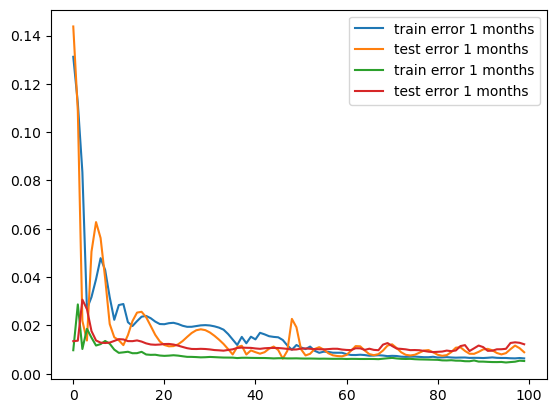

In [41]:
source_state_dict, target_state_dict, y_truth, y_forecast = forecast_maker(source_dataset, target_dataset, features, eval_dataset, [min,max])

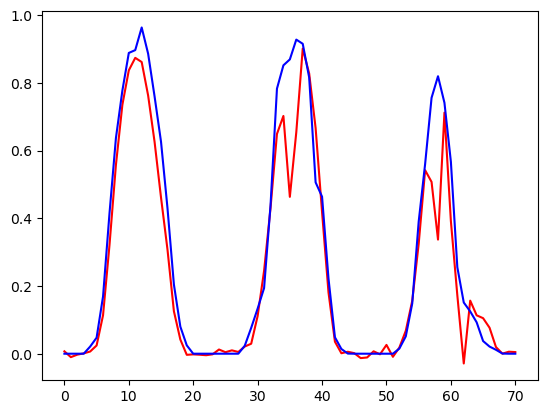

In [44]:
plt.figure()

day = 2
plt.plot(y_forecast[(24*day):(24*day)+71], color='red')
plt.plot(y_truth[(24*day):(24*day)+71], color='blue')

In [43]:
target_state_dict

OrderedDict([('source_lstm.weight_ih_l0',
              tensor([[-0.0249, -0.0217,  0.0502,  ...,  0.0196, -0.0142, -0.0054],
                      [ 0.0230,  0.0314,  0.0113,  ..., -0.0015,  0.0420,  0.0420],
                      [-0.0541,  0.0215, -0.0123,  ..., -0.0565, -0.0061, -0.0548],
                      ...,
                      [-0.0255,  0.0109, -0.0262,  ...,  0.0205, -0.0547,  0.0351],
                      [-0.0374, -0.0222, -0.0465,  ..., -0.0105, -0.0498, -0.0090],
                      [ 0.0248, -0.0296,  0.0386,  ..., -0.0201,  0.0033, -0.0078]])),
             ('source_lstm.weight_hh_l0',
              tensor([[ 0.0458, -0.0119, -0.0147,  ...,  0.0355, -0.0173, -0.0211],
                      [-0.0037,  0.0101,  0.0392,  ...,  0.0145,  0.0402, -0.0194],
                      [ 0.0443, -0.0086,  0.0074,  ..., -0.0082, -0.0186, -0.0526],
                      ...,
                      [-0.0148,  0.0008, -0.0405,  ...,  0.0154,  0.0337,  0.0166],
                   